#### 개요
* 터널을 지나는 차량 대수의 추세(trend) 분석

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

#### 설정

##### Matplotlib

In [3]:
# 기본 스타일 적용
# plt.style.use("seaborn-whitegrid")  # Matplotlib 3.6 이전 버전방식
plt.style.use("seaborn-v0_8-whitegrid")

# 그래프의 기본 크기 지정: 자동으로 조정되지만 비율은 11:5 인치
plt.rc("figure", autolayout=True, figsize=(11, 5))

# 그래프의 폰트 출력형태와 제목과 그래프사이의 간격 설정
plt.rc(
    "axes",
    labelweight="bold",         # 축의 레이블에 굵은 글꼴
    labelsize="large",          # 축의 레이블 크기를 'large'로 설정
    titleweight="bold",         # 제목을 굵은 글꼴
    titlesize=14,               # 제목 크기 14
    titlepad=10,                # 제목과 그래프 간격 10
)

# 그래프의 다양한 매개변수 지정
plot_params = dict(
    color="0.75",               # 그래프 색상(0.75는 회색)
    style=".-",                 # 그래프 스타일(점과 선으로 구성)
    markeredgecolor="0.25",     # 마커 테두리 색상(0.25는 회색의 명도)
    markerfacecolor="0.25",     # 마커 내부 색상
    legend=False,               # 범례 표시하지 않음
)

# 그래프 품질: 레티나(고품질)
%config InlineBackend.figure_format = 'retina'

#### 데이터 가져오기

In [7]:
DATA_PATH = Path('./data/')
tunnel_df_orginal = pd.read_csv(
    DATA_PATH/'tunnel.csv',
    parse_dates=['Day']         # 'Day'컬럼을 날짜 데이터 형식으로 읽음
)
tunnel_df_orginal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day          747 non-null    datetime64[ns]
 1   NumVehicles  747 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


In [8]:
tunnel_df = tunnel_df_orginal.set_index('Day').to_period()

In [9]:
tunnel_df.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [10]:
tunnel_df_orginal.head()

,Day,NumVehicles
0,2003-11-01,103536
1,2003-11-02,92051
2,2003-11-03,100795
3,2003-11-04,102352
4,2003-11-05,106569


#### 이동평균 구하기: with Pandas

In [13]:
moving_average_df = tunnel_df.rolling(
    window=365,         # 평균을 구한 창의 크기를 365(1년)으로 설정
    center=True,        # 평균을 창의 중심에 위치
    min_periods=183,    # 창의 크기가 최소 183(반년) 이상일때까지만 평균을 구함
).mean()

In [14]:
moving_average_df.head()

,NumVehicles
Day,
2003-11-01,99127.426230
2003-11-02,99094.489130
2003-11-03,99112.481081
2003-11-04,99146.639785
2003-11-05,99196.122995


#### 이동량 vs 이동평균 시각화

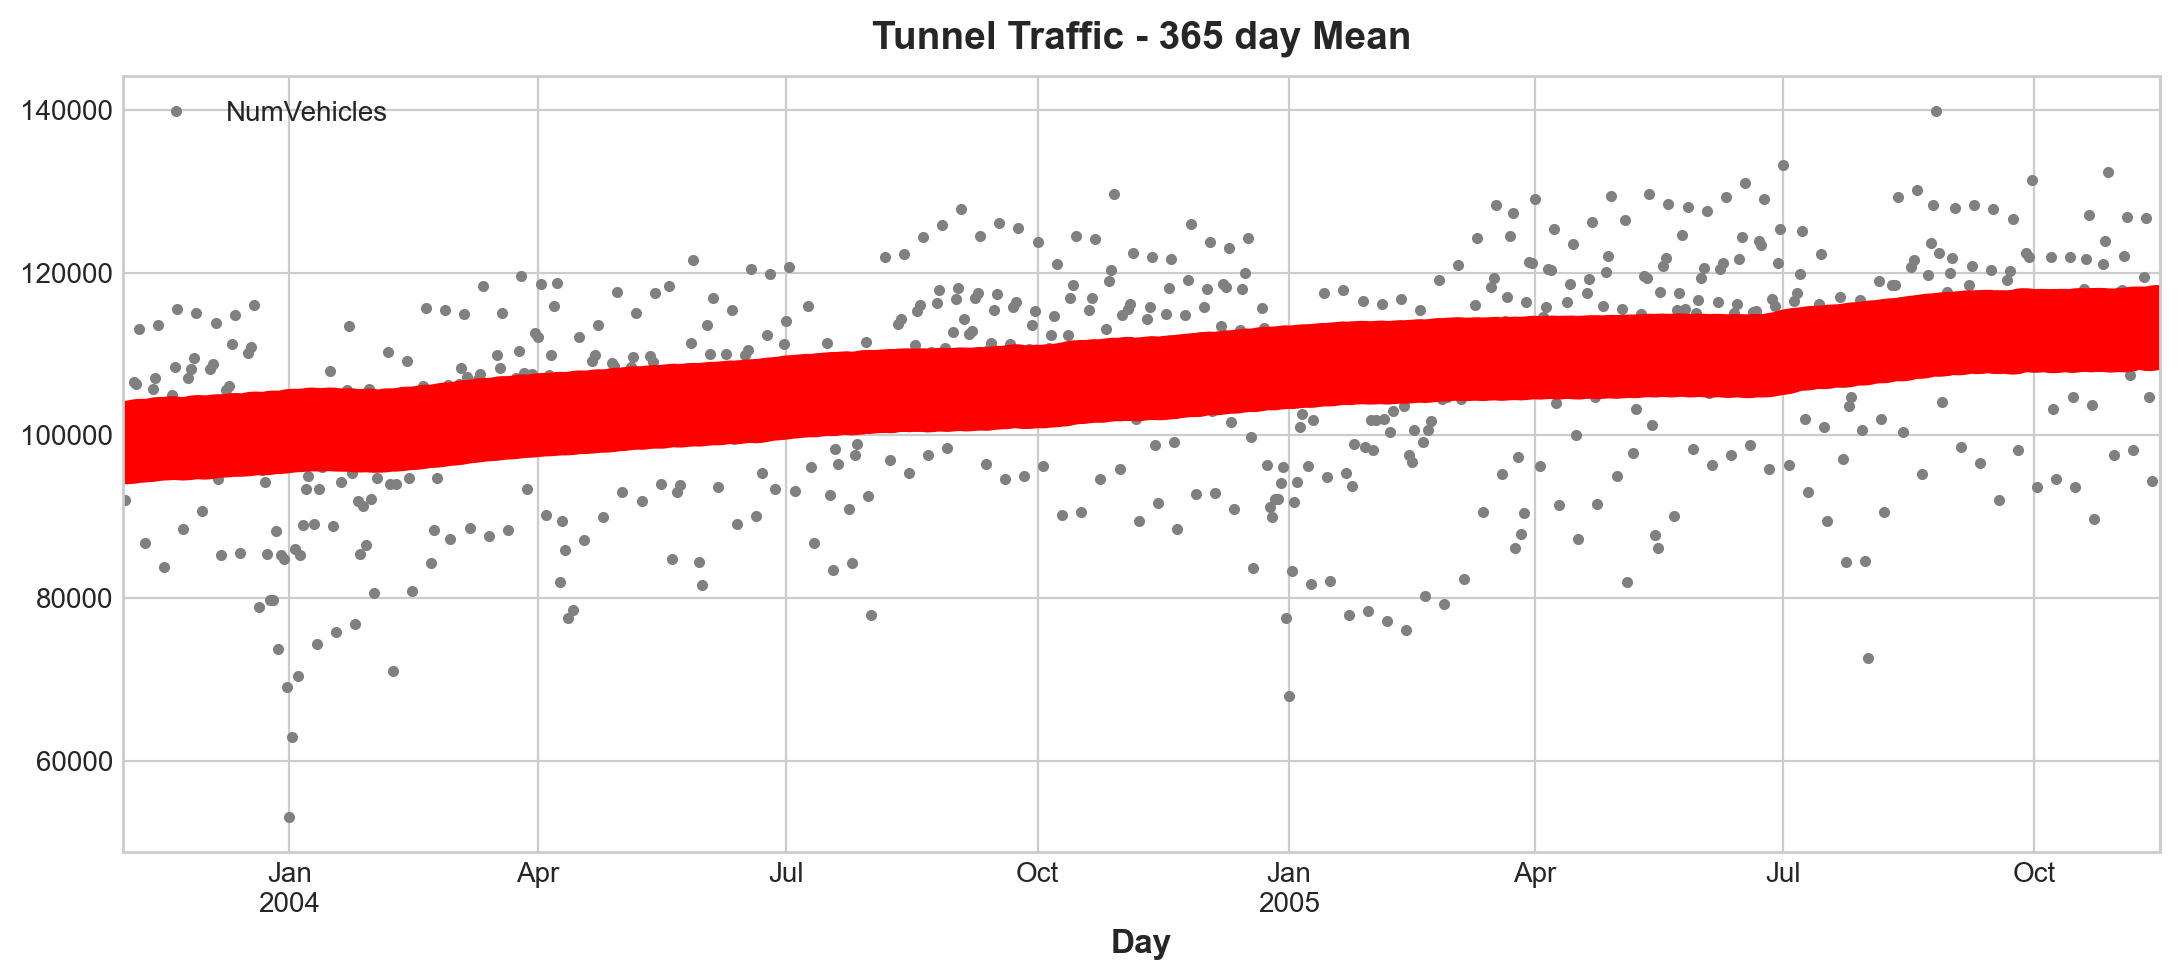

In [21]:
ax = tunnel_df.plot(style='.', color='0.5')
moving_average_df.plot(
    ax=ax,
    linewidth=30,
    title='Tunnel Traffic - 365 day Mean',
    color='red',
    legend=False
)
plt.show()

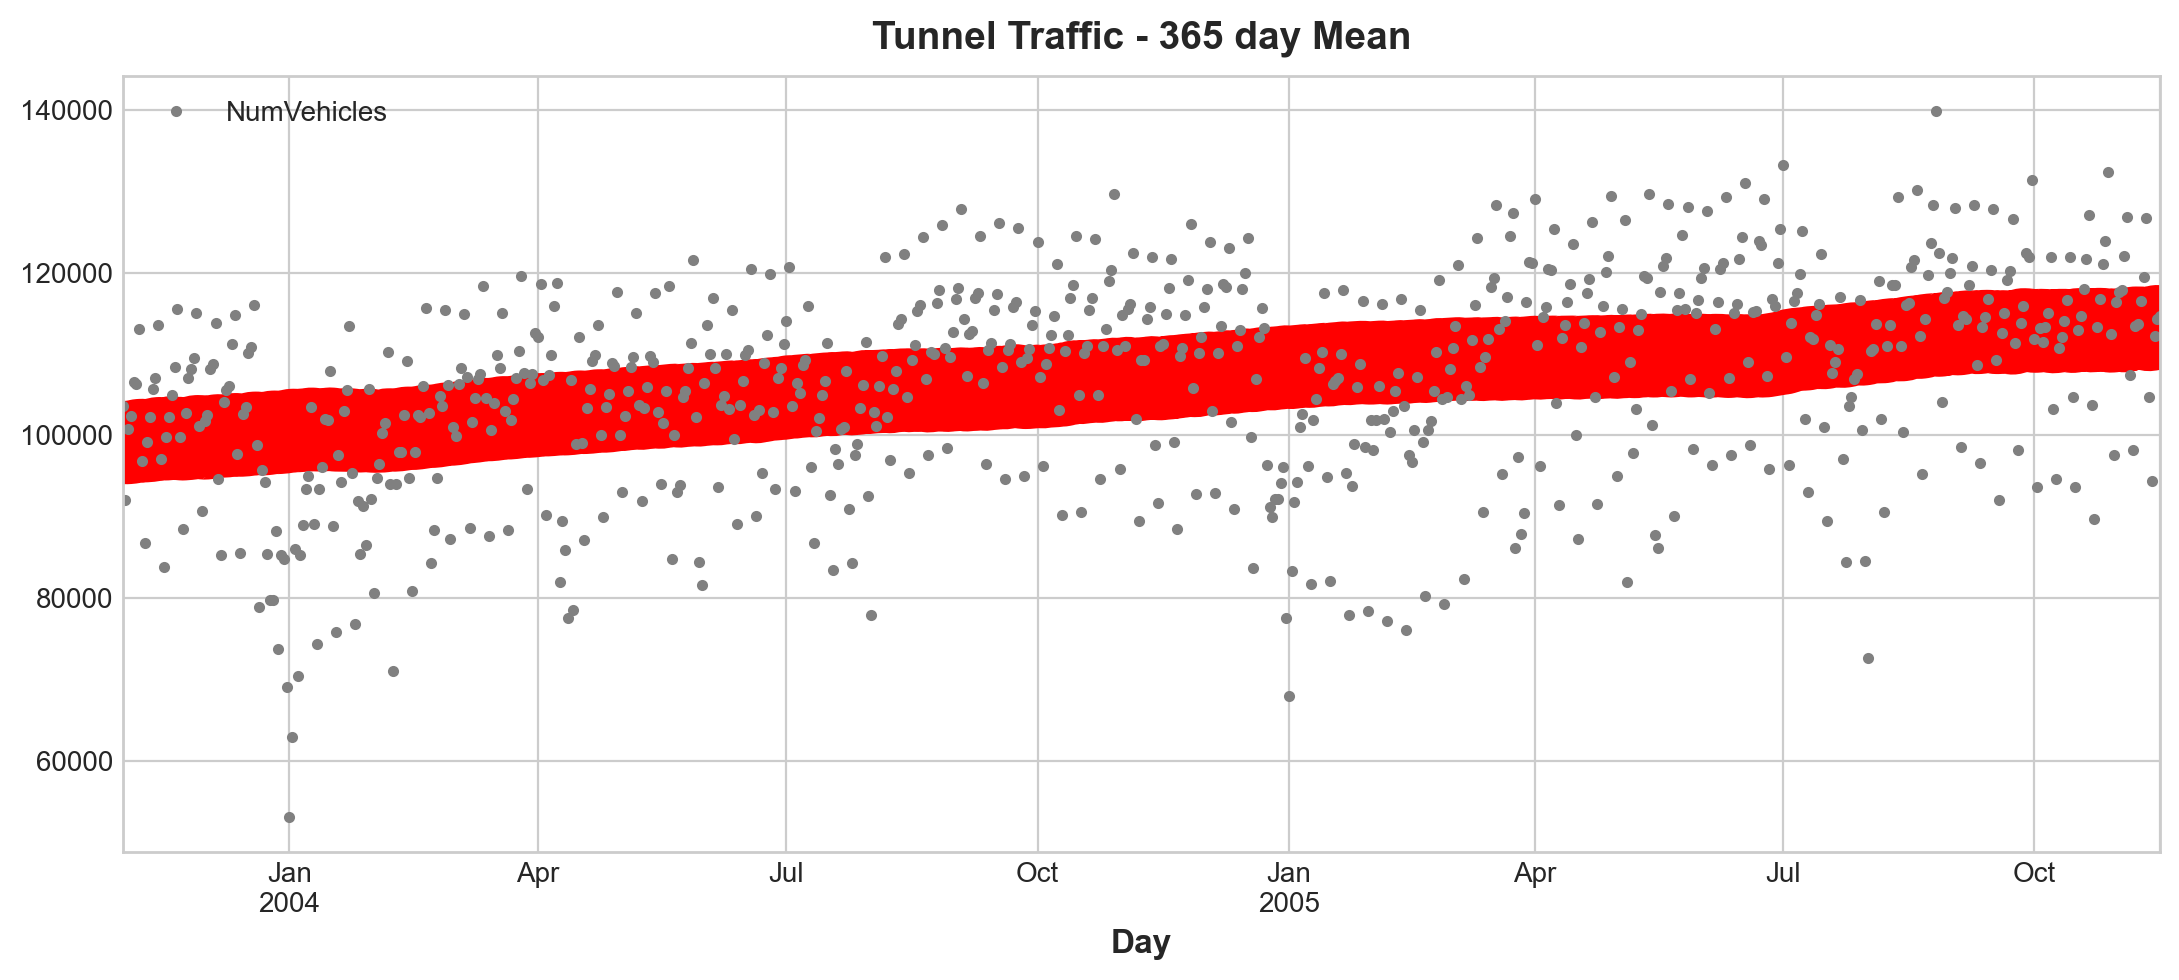

In [22]:
ax = moving_average_df.plot(
    linewidth=30,
    title='Tunnel Traffic - 365 day Mean',
    color='red',
    legend=False
)
tunnel_df.plot(ax=ax, style='.', color='0.5')
plt.show()

#### 이동평균 구하기: with Statsmodels

In [23]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [24]:
dp = DeterministicProcess(
    index=tunnel_df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

In [25]:
samples_df = dp.in_sample()
samples_df.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


#### 모델링

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
y = tunnel_df['NumVehicles']

model = LinearRegression(fit_intercept=False)
model.fit(samples_df, y)

LinearRegression(fit_intercept=False)

In [28]:
predictions = pd.Series(model.predict(samples_df), index=samples_df.index)

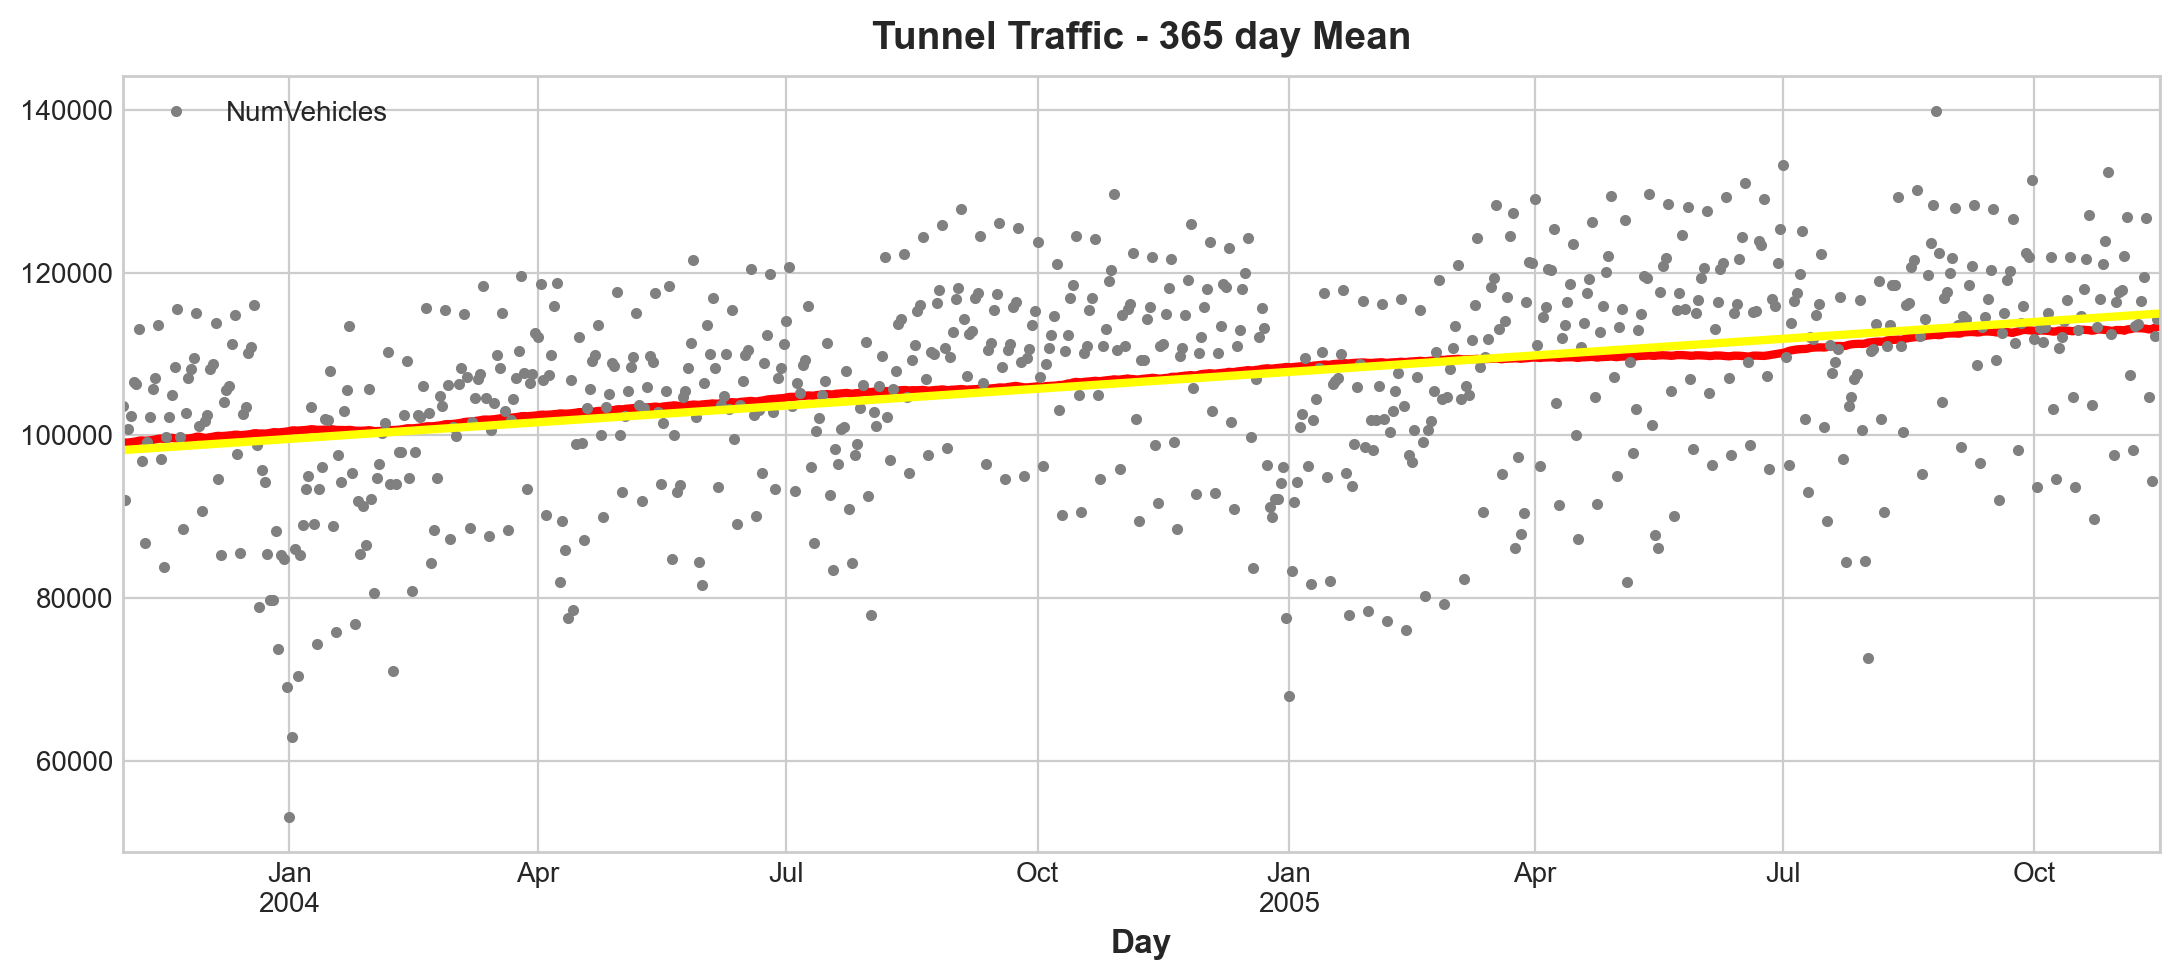

In [32]:
ax = moving_average_df.plot(
    linewidth=3,
    title='Tunnel Traffic - 365 day Mean',
    color='red',
    legend=False
)
tunnel_df.plot(ax=ax, style='.', color='0.5')
predictions.plot(ax=ax, linewidth=3, color='yellow')
plt.show()

#### 이후 30일 동안의 추세 표시

In [38]:
trend_inputs_df = dp.out_of_sample(steps=30)
trend_predict = pd.Series(
    model.predict(trend_inputs_df), 
    index=trend_inputs_df.index,
)

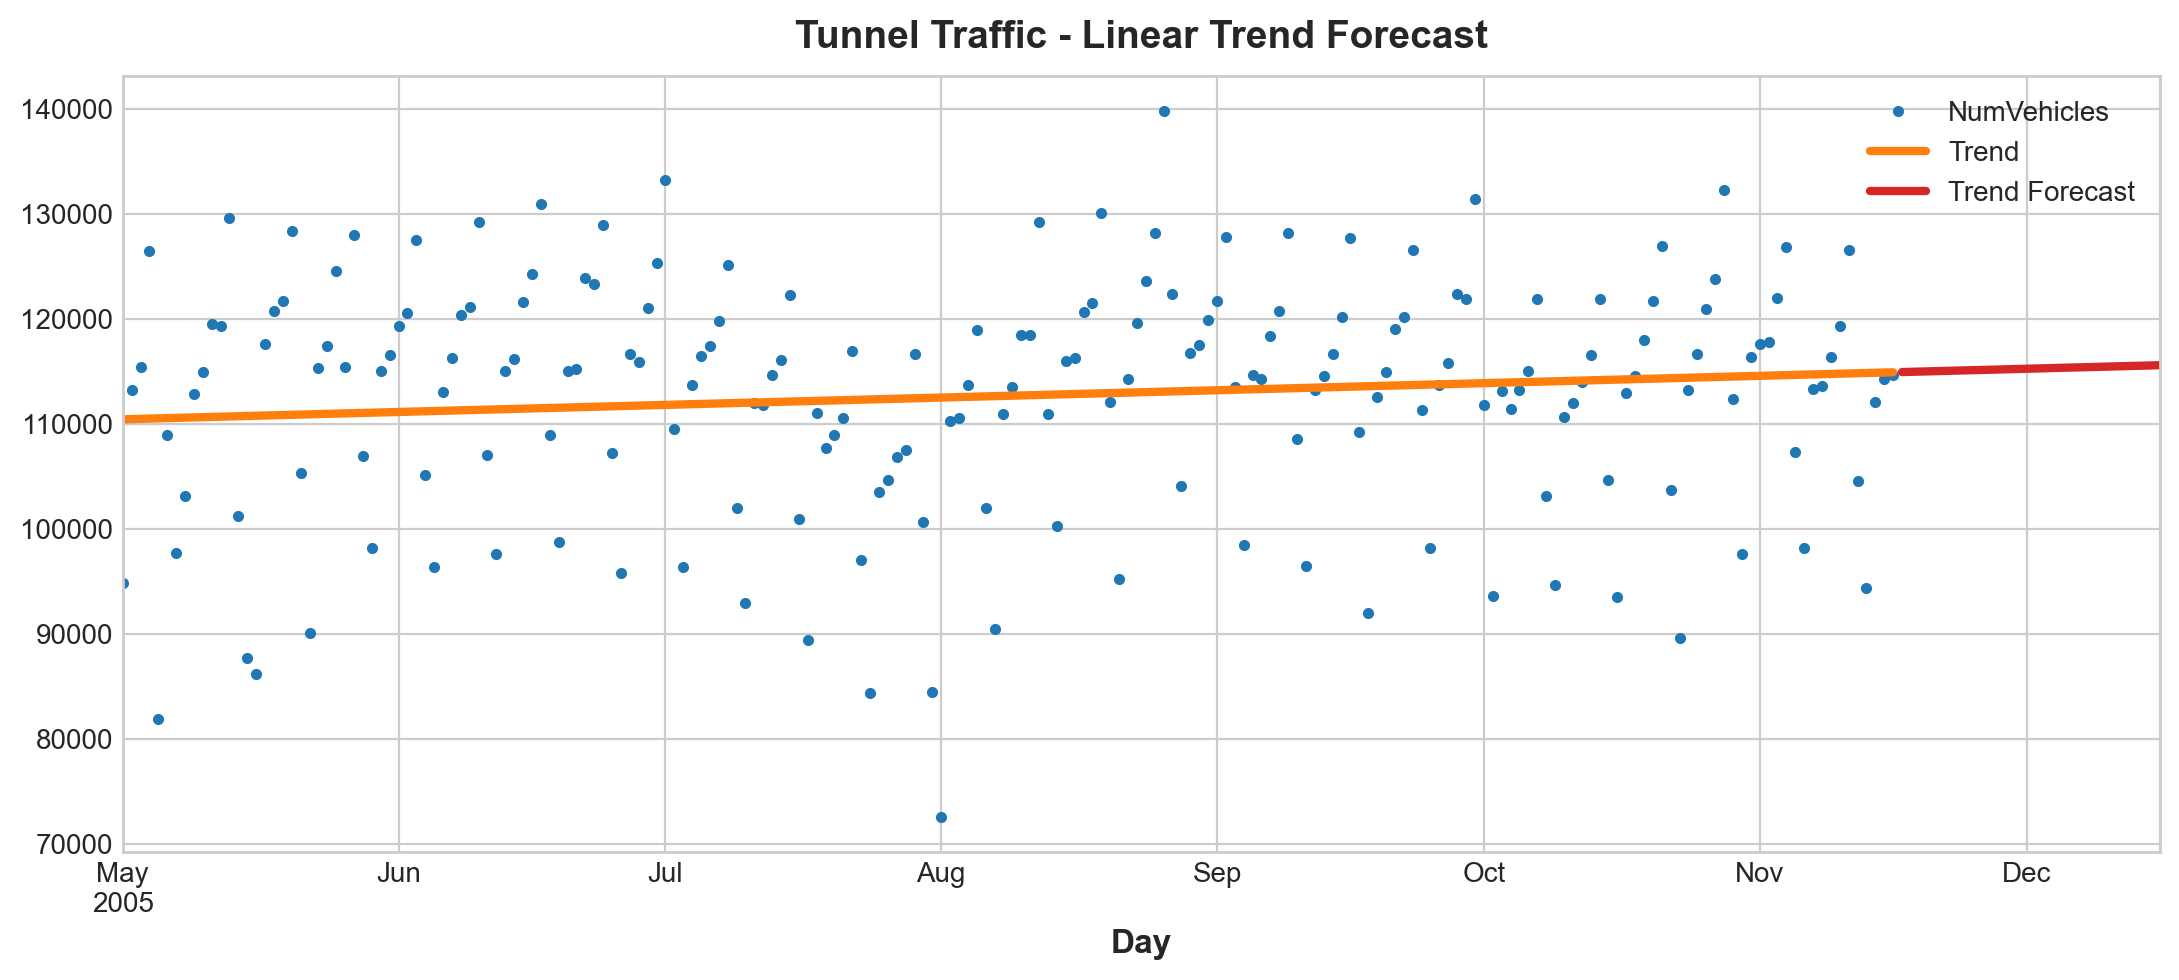

In [42]:
ax = tunnel_df["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", style='.')
# ax = tunnel_df["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = predictions["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = trend_predict.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

In [43]:
trend_predict.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

In [52]:
date = pd.to_datetime('2005-11-21')
base_date = pd.to_datetime('2005-11-17')
trend_predict[(date-base_date).days]

115071.79094373508

In [53]:
date = pd.to_datetime('2005-11-21').value
base_date = pd.to_datetime('2005-11-17').value
trend_predict[(date-base_date)//(24 * 60 * 60 * 10**9)]

115071.79094373508